**YOLO v4 - PyTorch - UDXLAV**

# Step 01. Check the colab enviroment

The GPUs available in Colab often include Nvidia K80s, T4s, P4s and P100s.

In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

!cat /proc/meminfo

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9517320159689464898
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1552194110454417329
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
MemTotal:       13297228 kB
MemFree:         8355036 kB
MemAvailable:   11886504 kB
Buffers:          333344 kB
Cached:          3140556 kB
SwapCached:            0 kB
Active:           538664 kB
Inactive:        4038300 kB
Active(anon):        900 kB
Inactive(anon):   860168 kB
Active(file):     537764 kB
Inactive(file):  3178132 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             33200 kB
Writeback:             0 kB
AnonPages:       1103116 kB
Mapped:           660088 kB
Shmem:             11428 kB

Install the newest numpy version

In [6]:
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.1 MB 13.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.4.0 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
plotnine 0.8.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
mizani 0.7.3 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but yo

In [2]:
import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

0
1
Tesla T4
True
Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


# Step 02. Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Step 03. Download YOLOv4 PyTorch repo

In [4]:
%cd /content/gdrive/My\ Drive
%mkdir colab
%cd /content/gdrive/My\ Drive/colab
!rm -rf pytorch-YOLOv4
!git clone https://github.com/nmhunguni/pytorch-YOLOv4
%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4

/content/gdrive/My Drive
mkdir: cannot create directory ‘colab’: File exists
/content/gdrive/My Drive/colab
Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 400, done.
remote: Total 400 (delta 0), reused 0 (delta 0), pack-reused 400
Receiving objects: 100% (400/400), 923.43 KiB | 9.93 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/gdrive/My Drive/colab/pytorch-YOLOv4


# Step 04. Set up YOLOv4 PyTorch Environment

In [5]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.6 MB 1.3 MB/s 
     |████████████████████████████████| 753.4 MB 21 kB/s 
     |████████████████████████████████| 26.5 MB 1.2 MB/s 
     |████████████████████████████████| 36.8 MB 1.1 MB/s 
     |████████████████████████████████| 59 kB 7.5 MB/s 
     |████████████████████████████████| 125 kB 73.1 MB/s 
  Created wheel for matplotlib: filename=matplotlib-2.2.3-cp38-cp38-linux_x86_64.whl size=10554071 sha256=06c8361c6f15d86d159af298ac6b515303fa41743f8a13cf632be0bcd0a08846
  Stored in directory: /root/.cache/pip/wheels/32/9e/42/1c91b0d0aa4bc87be038ee6aa88f303df10286c165feaa9823
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6360 sha256=62223a590b480328c590f30af7f743cc7a217d92be3d07cb1340942839e82918
  Stored in directory: /root/.cache/pip/wheels/d3/e0/e9/305e348717e399665119bd012510d51ff4f22d709ff60c3096
Successfully built 

# Step 05. Prepare data

In [13]:
# Step 04.1.1 Unzip dataset / manual in Google Drive

!rm -rf /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip
!unzip /content/gdrive/My\ Drive/colab/data/Vehicles-OpenImages.v1-416x416.yolov4pytorch.zip -d /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip

Archive:  /content/gdrive/My Drive/colab/data/Vehicles-OpenImages.v1-416x416.yolov4pytorch.zip
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/README.dataset.txt  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/README.roboflow.txt  
   creating: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/00dea1edf14f09ab_jpg.rf.KJ730oDTFPdXdJxvSLnX.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/00e481ea1a520175_jpg.rf.6e6a8b3b45c9a11d106958f88ff714ea.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/00e481ea1a520175_jpg.rf.MV6sZ8QCFwFeMYaI2tHm.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/08c8b73e0c2e296e_jpg.rf.7IkYAamjZhnwsoXSrwK

In [14]:
# Step 04.1.2 Prepare dataset & weights (by unzip file)

%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4

!rm -rf train
%mkdir train
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_annotations.txt train/train.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_classes.txt train/_classes.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_annotations.txt train.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/*.jpg train/
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/valid/*.jpg train/

!rm -rf data
%mkdir data
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/valid/_annotations.txt data/val.txt

!rm -rf test
%mkdir test
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/test/_classes.txt test/_classes.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/test/*.jpg test/

/content/gdrive/My Drive/colab/pytorch-YOLOv4


In [15]:
# Step 04.3 Check the number of classes

def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_classes.txt')
print(num_classes)

5


# Step 06. Training

In [16]:
# prepare pre-trained weights

# copy converted pre-trained weights
%cp /content/gdrive/My\ Drive/colab/weights/yolov4.conv.137.pth yolov4.conv.137.pth

In [17]:
#start training
#-b batch size (you should keep this low (2-4) for training to work properly)
#-s number of subdivisions in the batch, this was more relevant for the darknet framework
#-l learning rate
#-g direct training to the GPU device
#pretrained invoke the pretrained weights that we downloaded above
#classes - number of classes
#dir - where the training data is
#epoch - how long to train for

%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4
!python train.py -b 4 -s 1 -l 0.001 -g 0 -pretrained ./yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 25

/content/gdrive/My Drive/colab/pytorch-YOLOv4
log file path:log/log_2022-12-08_02-32-45.txt
2022-12-08 02:32:45,831 train.py[line:435] INFO: Using device cuda
2022-12-08 02:32:49,280 train.py[line:268] INFO: Starting training:
        Epochs:          25
        Batch size:      4
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   878
        Validation size: 250
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 5
        Train label path:train.txt
        Pretrained:
    
Epoch 1/25:   0%|        | 0/878 [00:00<?, ?img/s]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/25:   9%| | 76/878 [00:18<02:19,  5.74img//usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the

In [18]:
# continue training from the checkpoints
!python train.py -b 4 -s 1 -l 0.001 -g 0 -pretrained ./checkpoints/Yolov4_epoch1.pth -classes {num_classes} -dir ./train -epochs 25

log file path:log/log_2022-12-08_03-43-40.txt
2022-12-08 03:43:40,835 train.py[line:435] INFO: Using device cuda
2022-12-08 03:43:45,461 train.py[line:268] INFO: Starting training:
        Epochs:          25
        Batch size:      4
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   878
        Validation size: 250
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 5
        Train label path:train.txt
        Pretrained:
    
Epoch 1/25:   0%|        | 0/878 [00:00<?, ?img/s]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/25:   9%| | 76/878 [00:18<02:27,  5.43img//usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler,

# Step 07. Test the results

In [19]:
# Check the trained weights

!ls checkpoints


Yolov4_epoch10.pth  Yolov4_epoch17.pth	Yolov4_epoch23.pth  Yolov4_epoch6.pth
Yolov4_epoch11.pth  Yolov4_epoch18.pth	Yolov4_epoch24.pth  Yolov4_epoch7.pth
Yolov4_epoch12.pth  Yolov4_epoch19.pth	Yolov4_epoch25.pth  Yolov4_epoch8.pth
Yolov4_epoch13.pth  Yolov4_epoch1.pth	Yolov4_epoch2.pth   Yolov4_epoch9.pth
Yolov4_epoch14.pth  Yolov4_epoch20.pth	Yolov4_epoch3.pth
Yolov4_epoch15.pth  Yolov4_epoch21.pth	Yolov4_epoch4.pth
Yolov4_epoch16.pth  Yolov4_epoch22.pth	Yolov4_epoch5.pth


In [20]:
# Choose random test image

import os
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

print(img_path)


test/e36e433eed49a09d_jpg.rf.8826d7fb567c1288c0188105137f280a.jpg


Bus: 0.999999
save plot results to predictions.jpg


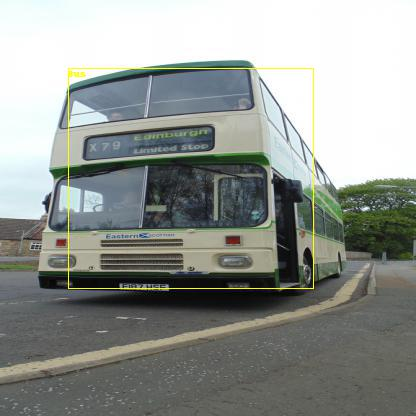

In [21]:
# Run test for a random image using a chosen checkpoints and visualization the result
w = int(608)
!python models.py {num_classes} checkpoints/Yolov4_epoch25.pth {img_path} test/_classes.txt

from IPython.display import Image
Image('predictions.jpg')

In [22]:
!pwd

/content/gdrive/MyDrive/colab/pytorch-YOLOv4


In [23]:
num_classes

5